# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---


### What Can the Project Do

In this notebook, I will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, my code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of my finished project. 


### The Road Ahead

I break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, I import a dataset of dog images.  I populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [65]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('/Users/wkw/yl/dog-project-master/dogImages/train')
valid_files, valid_targets = load_dataset('/Users/wkw/yl/dog-project-master/dogImages/valid')
test_files, test_targets = load_dataset('/Users/wkw/yl/dog-project-master/dogImages/test')
# train_files, train_targets = load_dataset('dogImages/train')
# valid_files, valid_targets = load_dataset('dogImages/valid')
# test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("/Users/wkw/yl/dog-project-master/dogImages/train/*"))]
# print(dog_names)
# print(len(dog_names))#133
# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

133
There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, I import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [25]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("/Users/wkw/yl/dog-project-master/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

I use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, I demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


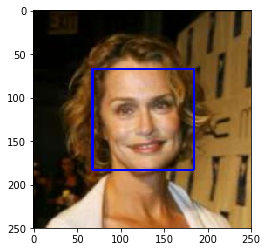

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [26]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`. The percentage of the first 100 images in dog_files have a detected human face is: 12.0%

In [66]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]


## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
# Test the performance of the face_detoctor algorithm on the images in human_files_short
human_count=0
# human_per=0
for img in human_files_short:
    if face_detector(img) is True:
        human_count +=1
human_per = (human_count / 100) *100.0
print('The percentage of the first 100 images in human_files have a detected human face is: {}%'.format(human_per))

# Test the performance of the face_detoctor algorithm on the images in dog_files_short
dog_count=0
for img in dog_files_short:
    if face_detector(img) is True:
        dog_count +=1

dog_per = (dog_count / 100) *100.0
print('The percentage of the first 100 images in dog_files have a detected human face is: {}%'.format(dog_per))
        

The percentage of the first 100 images in human_files have a detected human face is: 98.0%
The percentage of the first 100 images in dog_files have a detected human face is: 12.0%


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [33]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths. 

In [34]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`. 

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [36]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [37]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return prediction <= 268 and prediction >= 151

### Assess the Dog Detector

The code cell below to test the performance of my `dog_detector` function. The percentage of the images in human_files have a detected dog is 1.0%. The percentage of the images in dog_files have a detected dog is 100.0%.

In [67]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
# Test the performance of the dog_detoctor algorithm on the images in human_files_short

dog_count=0
for img in human_files_short:
    if dog_detector(img):
        dog_count +=1
doginhuman_per = (dog_count / 100) *100.0
print('The percentage of the images in human_files have a detected dog is: {}%'.format(doginhuman_per))
# Test the performance of the dog_detoctor algorithm on the images in dog_files_short
dog_count=0
for img in dog_files_short:
    if dog_detector(img):
        dog_count +=1
        dog_per = (dog_count / 100) *100.0
print('The percentage of the images in dog_files have a detected dog is: {}%'.format(dog_per))

The percentage of the images in human_files have a detected dog is: 1.0%
The percentage of the images in dog_files have a detected dog is: 100.0%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images. A CNN that classifies dog breeds is created from scratch and attain a test accuracy of at least 1%. 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [41]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:07<00:00, 116.24it/s]


### Model Architecture

Outline the steps of the CNN architecture and my reasoning at each step.  
- `step 1`: declear sequential model. This is a way to create CNN where Sequential class is created and model layers are created and added to it. 

- `step 2`: read the input layer and create the first set of convolutional and pooling layer. The first convolutional layer is to read the input layer and set the inital filter number. The filter number should increase with the increase of the convolutional layer to capture more features. The pooling layer after each convolutional layer is to deeper the feature and extrapolate into a deeper dimension. 

- `step 3`: Add two sets of convolutional layers and pooling layers. 
- `step 4`: Add dropout layer to prevent overfitting. 
- `step 5`: Add fully connected layer and then the output layer. The final layer has an output size of 133, corresponding to the 133 dog breeds. 
- `step 6`: Summary the model.

In [43]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

#declare sequential model
model = Sequential()

### Define your architecture.
#CNN input layer
model.add(Conv2D(filters=16,kernel_size=2,padding='same',activation='relu',input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32,kernel_size=2,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64,kernel_size=2,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.3))

#Fully connected Dense layers
model.add(Flatten())
model.add(Dense(500,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(133,activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0         
__________

### Compile the Model

In [44]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

In [45]:
from keras.callbacks import ModelCheckpoint  

### specify the number of epochs that you would like to use to train the model.

epochs =10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6660/6680 [============================>.] - ETA: 1s - loss: 4.9047 - acc: 0.0224
Epoch 00001: val_loss improved from inf to 4.60935, saving model to saved_models/weights.best.from_scratch.hdf5
6680/6680 [==============================] - 378s 57ms/step - loss: 4.9049 - acc: 0.0223 - val_loss: 4.6093 - val_acc: 0.0467
Epoch 2/10
6660/6680 [============================>.] - ETA: 2s - loss: 4.3548 - acc: 0.0671
Epoch 00002: val_loss improved from 4.60935 to 4.26295, saving model to saved_models/weights.best.from_scratch.hdf5
6680/6680 [==============================] - 775s 116ms/step - loss: 4.3540 - acc: 0.0674 - val_loss: 4.2629 - val_acc: 0.0659
Epoch 3/10
6660/6680 [============================>.] - ETA: 1s - loss: 3.6458 - acc: 0.1754
Epoch 00003: val_loss improved from 4.26295 to 4.17181, saving model to saved_models/weights.best.from_scratch.hdf5
6680/6680 [==============================] - 363s 54ms/step - loss: 3.6457 - 

### Load the Model with the Best Validation Loss

In [46]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out my CNN model on the test dataset of dog images.  Ensure that my test accuracy is greater than 1%.

In [47]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 8.2536%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we should train a CNN using transfer learning.  

### Obtain Bottleneck Features

In [48]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [49]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [50]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [51]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6560/6680 [============================>.] - ETA: 0s - loss: 12.4022 - acc: 0.1201
Epoch 00001: val_loss improved from inf to 10.33673, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 5s 819us/step - loss: 12.3928 - acc: 0.1207 - val_loss: 10.3367 - val_acc: 0.2156
Epoch 2/20
6500/6680 [============================>.] - ETA: 0s - loss: 9.6340 - acc: 0.2940
Epoch 00002: val_loss improved from 10.33673 to 9.51786, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 2s 294us/step - loss: 9.6195 - acc: 0.2958 - val_loss: 9.5179 - val_acc: 0.3114
Epoch 3/20
6480/6680 [============================>.] - ETA: 0s - loss: 8.9515 - acc: 0.3724
Epoch 00003: val_loss improved from 9.51786 to 9.15511, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 2s 287us/step - loss: 8.9341 - acc: 0.3731 - val_lo

### Load the Model with the Best Validation Loss

In [52]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [53]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 50.5981%


### Predict Dog Breed with the Model

In [54]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

Now, I will use transfer learning to create a CNN that can identify dog breed from images.  This CNN can attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, I use the bottleneck features from VGG19 and ResNet50 pre-trained models. The pre-computed features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [55]:
### Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogVGG19Data.npz')
train_VGG19 = bottleneck_features['train']
valid_VGG19 = bottleneck_features['valid']
test_VGG19 = bottleneck_features['test']

### Model Architecture

Instead of start a CNN from scratch, I used a pre-train ResNet50 model and its bottleneck features through transfer learning. Outline of my CNN model and reasoning at each step:

- `step 1`: load the bottleneck features, which are the output of pre-trained ResNet "truncated" the fully connected layer model. These features are the inputs fill my model.   
- `step 2`: declear sequential model to ResNet50. This is a way to create CNN where Sequential class is created and model layers are created and added to it. 
- `step 3`: add global average pooling layer, which will greatly reduced number of parameters need to train. Compared with fully connected layers,global average pooling is more meaningful and interpretable, which is made possible by a stronger local modeling using the micro network.  Furthermore, the fully connected layers are prone to overfitting, while global average pooling is itself a structural regularizer, which natively prevents overfitting for the overall structure.
- `step 4`: Add dense layer, which will fit the output to  This is the only layer that is trained in my model.  
- `step 5`: Complie the model and train the model. 

My final CNN model reaches 78% of accuracy. Using VGG19 model, the accuracy is 51%. Then switching to ResNet-50 bottleneck feature model, the accuracy improves to 78%. 
VGG19 and VGG16 need pre-training. It is a very time consuming, tedious task, which requirs an entire network to be trained before it can serve as an initialization for a deeper network. Unfortunately, VGGNet is slow to train, and the network architecture weights themselves are quite large. Compare to VGGNet, ResNet provides a much deeper architecture and the model size is substantially smaller due to the usage of global average pooling rather than fully-connected layers.




In [56]:
### Define model architecture.
VGG19_model = Sequential()
VGG19_model.add(GlobalAveragePooling2D(input_shape=train_VGG19.shape[1:]))
VGG19_model.add(Dense(133, activation='softmax'))

VGG19_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [57]:
### Compile the model.
VGG19_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

Train the model in the code cell below. Use model checkpointing to save the model that attains the best validation loss. 

In [58]:
### Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG19.hdf5', 
                               verbose=1, save_best_only=True)

VGG19_model.fit(train_VGG19, train_targets, 
          validation_data=(valid_VGG19, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6560/6680 [============================>.] - ETA: 0s - loss: 11.3636 - acc: 0.1518
Epoch 00001: val_loss improved from inf to 9.68735, saving model to saved_models/weights.best.VGG19.hdf5
6680/6680 [==============================] - 7s 975us/step - loss: 11.3514 - acc: 0.1530 - val_loss: 9.6873 - val_acc: 0.2503
Epoch 2/20
6620/6680 [============================>.] - ETA: 0s - loss: 8.8654 - acc: 0.3437
Epoch 00002: val_loss improved from 9.68735 to 8.83327, saving model to saved_models/weights.best.VGG19.hdf5
6680/6680 [==============================] - 3s 427us/step - loss: 8.8723 - acc: 0.3436 - val_loss: 8.8333 - val_acc: 0.3305
Epoch 3/20
6580/6680 [============================>.] - ETA: 0s - loss: 8.3314 - acc: 0.4146
Epoch 00003: val_loss improved from 8.83327 to 8.54747, saving model to saved_models/weights.best.VGG19.hdf5
6680/6680 [==============================] - 3s 393us/step - loss: 8.3095 - acc: 0.4157 - val_loss:

### Load the Model with the Best Validation Loss

In [59]:
### Load the model weights with the best validation loss.
VGG19_model.load_weights('saved_models/weights.best.VGG19.hdf5')

### Test the Model

Try out my model on the test dataset of dog images and the test accuracy is 51%.

In [60]:
### Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
VGG19_predictions = [np.argmax(VGG19_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG19]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG19_predictions)==np.argmax(test_targets, axis=1))/len(VGG19_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 51.4354%


In [62]:
# ResNet-50 bottleneck features
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### Define your architecture.
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

### Compile the model.
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

### Load the model weights with the best validation loss.
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________
Train on 6680 samples, validate on 835 samples
Epoch 1/20
6640/6680 [============================>.] - ETA: 0s - loss: 1.6388 - acc: 0.5970
Epoch 00001: val_loss improved from inf to 0.83616, saving model to saved_models/weights.best.Resnet50.hdf5
6680/6680 [==============================] - 6s 863us/step - loss: 1.6345 - acc: 0.5978 - val_loss: 0.8362 - val_acc: 0.7401
Epoch 2/20
6520/6680 [============================>.] - ETA: 0s - loss: 0.4455 - acc: 0.8632
Epoch 00002: val_loss improved from 0.83616 to 0.66300, saving model

### Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [68]:
def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write Own Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.


### Write Algorithm

In [102]:
### Write your algorithm.
### Feel free to use as many code cells as needed.
# The dog in the image is American water spanie.
img_path="/Users/wkw/yl/test/aws.jpg"
actual_breed_pos1 = img_path.rfind('/')
actual_breed_pos2 = img_path.find('.')

def dog_breed(img_path):
    dog_breed=Resnet50_predict_breed(img_path)
    pos = dog_breed.rfind('.')+1
    if dog_detector(img_path):
        actual_breed_pos1 = img_path.rfind('/')
        actual_breed_pos2 = img_path.find('.')
        print("It is actually a %s" %img_path[actual_breed_pos1+1:actual_breed_pos2])
        print("The algorithm predicts as %s" %dog_breed[pos:])
    elif face_detector(img_path):
        print("You look like a ... \n %s" % dog_breed[pos:])
    else:
        print("Neither human face nor dog is detected in the image. Please check.")
    
dog_breed(img_path)
    

It is actually a aws
The algorithm predicts as Irish_water_spanie


---
<a id='step7'></a>
## Step 7: Test The Algorithm

In this section, I will take my new algorithm for a spin! My algorithm will tell you what kind of dog do you look like. Ff you have a dog, upload its photo and check if it predict the breed accurately. 

### Test The Algorithm 

My algorithm is tested on six images from internet. Among all six tested images, the algorithm successfully predicted 5 dogs/human faces. The accuracy is ~83%, which is better than my expection. There are three possible ways to improve the algorith: train the algorithm in a bigger training database, improve the efficiency, and add some body feature to predict images the face regardless body in the image of not. 

It is actually a Brittany
The algorithm predicts as Brittan


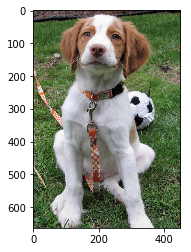

It is actually a Curly-coated_retriever
The algorithm predicts as Curly-coated_retrieve


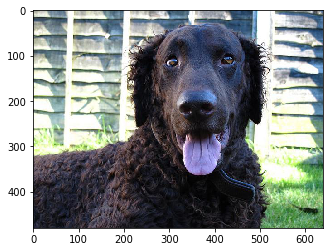

It is actually a Labrador_retriever
The algorithm predicts as Labrador_retrieve


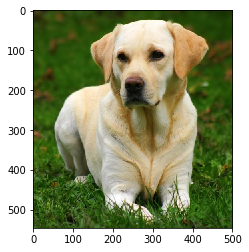

You look like a ... 
 Basenj


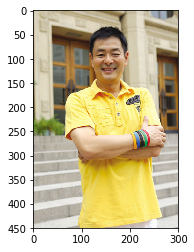

You look like a ... 
 Beagl


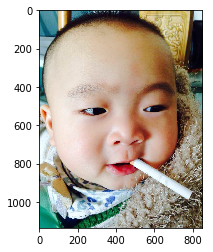

Neither human face nor dog is detected in the image. Please check.


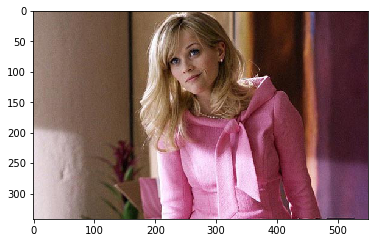

In [119]:
img_path_list = ["/Users/wkw/yl/test/Brittany.jpg","/Users/wkw/yl/test/Curly-coated_retriever.jpg","/Users/wkw/yl/test/Labrador_retriever.jpg","/Users/wkw/yl/test/actor.jpg", "/Users/wkw/yl/test/baby1.jpg", "/Users/wkw/yl/test/actress.jpg"]
for img_path in img_path_list:
    dog_breed(img_path)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.show()
    
    